# Part 1. Segmentation — 10 points

### Task

Train a neural network to segment cells edges.

In this task, you won't be provided with any code snippets, just input data and target metric — intersection-over-union (IoU) (see the implementation below).

You should train your neural network to predict a mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you have learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions), we recommend using UNet: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You are not allowed to do only one thing: to train you network on a test set.

The final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

A good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain similar or better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [1]:
### Download the dataset ###
!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
!unzip -q data.zip

--2020-05-12 17:23:46--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2020-05-12 17:23:46--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc43e99f6547fb50643bbe9696e4.dl.dropboxusercontent.com/cd/0/inline/A3m82vKnYfyvERvJxg9hgzwKtOTTVOWQn-D4jcVj0fbxNXTu2pDnYthUHhol8CsvtX6743ZUzqKj5Eagl8NITbU5tPVOE2J8Z5zGaBIoddEGmA/file# [following]
--2020-05-12 17:23:46--  https://uc43e99f6547fb50643bbe9696e4.dl.dropboxusercontent.com/cd/0/inline/A3m82vKnYfyvERvJxg9hgzwKtOTTVOWQn-D4jcVj0fbxNXTu2pDnYthUHhol8CsvtX6743ZUzqKj5Eagl8NITbU5tPVOE2J8Z5zGaBIoddEGmA/file
Resolving uc43e99f6547fb50

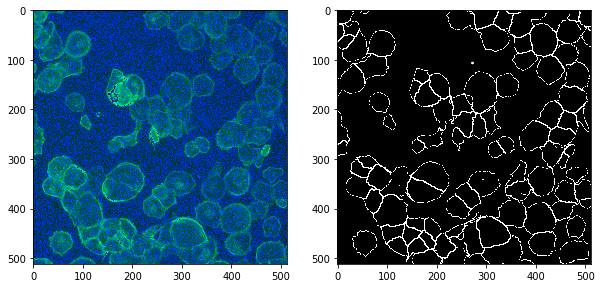

In [1]:
### Visualize the data ###
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline



# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

In [2]:
### Target metric ###
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
import random
from PIL import Image

In [4]:
class CellDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        super(Dataset, self).__init__()
        
        self.images = sorted(next(os.walk(images_dir))[2])
        self.labels = sorted(next(os.walk(labels_dir))[2])
        
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.images_dir, self.images[idx]))
        label = Image.open(os.path.join(self.labels_dir,self.labels[idx]))
        
        # augmentation
        
        seed = np.random.randint(2147483647) #make a seed
        if self.transform:
            
            random.seed(seed) # apply seed to image
            image = self.transform(image)
            
            random.seed(seed) # apply seed to label
            label = self.transform(label)
        return image, label

In [5]:
# YOUR CODE HERE

class DownBlock(nn.Module):

    def __init__(self, conv1, conv2):
        super().__init__()
        

        self.convs = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
            nn.ReLU()
        )
        
        self.pool = nn.MaxPool2d(kernel_size = 2)

    def forward(self, x):
        
        out_without_pool = self.convs(x)
        out = self.pool(out_without_pool)
        
        return out, out_without_pool

class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upsample = nn.Upsample(scale_factor = 2)
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x, x_skip_connection):
        out_upsample = self.upsample(x)
        #print(out_upsample.size(),x_skip_connection.size())
        out_concat = torch.cat([out_upsample, x_skip_connection], dim=1)
        out = self.convs(out_concat)
        return(out)
    
    
class Unet(nn.Module):
    
    def __init__(self, n_base_channels = 64):
        super().__init__()
        self.vgg = torchvision.models.vgg11(pretrained=True)
        self.down_blocks = nn.ModuleList([
            DownBlock(self.vgg.features[0], self.vgg.features[3]),
            DownBlock(self.vgg.features[6], self.vgg.features[8]),
            DownBlock(self.vgg.features[11], self.vgg.features[13]),
            DownBlock(self.vgg.features[16], self.vgg.features[18]),
            DownBlock(nn.Conv2d(n_base_channels * 8, n_base_channels * 8, kernel_size = 3, padding = 1),
                      nn.Conv2d(n_base_channels * 8, n_base_channels * 8, kernel_size = 3, padding = 1))
        ])
        self.up_blocks = nn.ModuleList([
            UpBlock(n_base_channels * 8, n_base_channels * 8),
            UpBlock(n_base_channels * 8, n_base_channels * 4),
            UpBlock(n_base_channels * 4, n_base_channels * 2),
            UpBlock(n_base_channels * 2, n_base_channels),
            #UpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, 1, kernel_size=1, padding=0),
            #nn.Conv2d(n_base_channels, 3, kernel_size=3, padding=1)
        )
    def forward(self, x):

        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, out_without_pooling = block(out)
            outputs_before_pooling.append(out_without_pooling)
        out = out_without_pooling

        for i, block in enumerate(self.up_blocks): 
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)

        return out
        

In [6]:
#balance weight
balance_weight = torch.Tensor([5.])

In [7]:
train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation((-5,5), fill=0),
        torchvision.transforms.RandomHorizontalFlip(p = 0.5),
        torchvision.transforms.RandomVerticalFlip(p = 0.5),
        #torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=0.3, interpolation=3),
        torchvision.transforms.ToTensor()
])
val_transform = torchvision.transforms.ToTensor()

train_dataset = CellDataset(images_dir = './BBBC018_v1_images-fixed/train',
                        labels_dir = './BBBC018_v1_outlines/train',
                        transform = train_transform)

val_dataset = CellDataset(images_dir = './BBBC018_v1_images-fixed/val',
                      labels_dir = './BBBC018_v1_outlines/val',
                      transform = val_transform)

train_dataloader = DataLoader(train_dataset, batch_size = 3, shuffle=True)


val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle=False)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

unet = Unet(n_base_channels = 64).to(device)

writer = SummaryWriter()

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = balance_weight).to(device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=10, verbose=True)
n_epochs = 150

In [18]:
!wget -O utils.py https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml


!pip install einops

--2020-05-12 18:57:45--  https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving drive.google.com (drive.google.com)... 172.217.204.139, 172.217.204.100, 172.217.204.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2p10mspd391ehqrlkdv6t1eljd5bgb13/1589309850000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml [following]
--2020-05-12 18:57:45--  https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2p10mspd391ehqrlkdv6t1eljd5bgb13/1589309850000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)... 108.177.11.132, 2607:f8b0:400c:c01::84
Connecting to doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)|10

In [17]:
%load_ext tensorboard
import os
logs_base_dir = "./runs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3234), started 1:43:23 ago. (Use '!kill 3234' to kill it.)

<IPython.core.display.Javascript object>

In [16]:
max_val_iou = 0

for i in range(n_epochs):

    train_loss = 0
    val_loss = 0
    
    train_iou = 0
    val_iou = 0
    

    predictions_train = []
    labels_train = []
    predictions_val = []
    labels_val = []

    unet.train()
    for X_batch, y_batch in train_dataloader:
          
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        #forward
        output = unet(X_batch)
        optimizer.zero_grad()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        y_pred = (output.detach().sigmoid() >= 0.5).cpu().numpy()
        predictions_train.append(y_pred)
        labels_train.append(y_batch.cpu().numpy())

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_iou = calc_iou(predictions_train, np.array(labels_train))

    # Validation
    unet.eval()
    for X_batch, y_batch in val_dataloader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        output = unet(X_batch)
        loss = criterion(output, y_batch)

        y_pred = (output.detach().sigmoid() >= 0.5).cpu().numpy()
        predictions_val.append(y_pred)
        labels_val.append(y_batch.cpu().numpy())

        val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_iou = calc_iou(predictions_val, np.array(labels_val))

    scheduler.step(val_loss)

    writer.add_scalar('Train Loss', train_loss, i)
    writer.add_scalar('Val Loss', val_loss, i)
    writer.add_scalar('Train IoU', train_iou, i)
    writer.add_scalar('Val IoU', val_iou, i)
    
    if val_iou > max_val_iou:
        max_val_iou = val_iou
        torch.save(unet.state_dict(), './unet_cell_segmentation.pt')
    print("Validation IoU:",val_iou)

Validation IoU: 0.013483237275752902
Validation IoU: 0.14788920273591608
Validation IoU: 0.1973828125
Validation IoU: 0.21448640564072433
Validation IoU: 0.22827789284044808
Validation IoU: 0.2501540707457898
Validation IoU: 0.25186358889409055
Validation IoU: 0.24854010500014037
Validation IoU: 0.21246614288929533
Validation IoU: 0.2579788749245126
Validation IoU: 0.24935696712144934
Validation IoU: 0.2781126052046048
Validation IoU: 0.2820258953137906
Validation IoU: 0.2718104420966253
Validation IoU: 0.26359276937213777
Validation IoU: 0.28180913432913657
Validation IoU: 0.2694976816074189
Validation IoU: 0.2683166447705531
Validation IoU: 0.28199736251202906
Validation IoU: 0.28257898299163775
Validation IoU: 0.2785746159240135
Validation IoU: 0.25975926026504453
Validation IoU: 0.2760424373057989
Validation IoU: 0.2683586676574347
Validation IoU: 0.2872610017826558
Validation IoU: 0.28339214655754935
Validation IoU: 0.2869119304532126
Validation IoU: 0.2861584446983622
Validation 

KeyboardInterrupt: ignored

In [20]:
max_val_iou

0.3047440010930661

## A brief history of tweaks and improvements:
* I started with shallow U-Net with 5 blocks and data augmentation but didn't get more than validation **IoU = 0.2**.
* After that I changed the Encoder to ImageNet pretrained VGG-11 and reached around **IoU = 0.22**.
* Finally I added Batchnormalization to Decoder and reached **IoU = 0.3** on validation set.
---
## You can see below the Val IoU and Train/Val Losses for 3 models and predicted Images:
* **Blue** : U-Net with VGG-11 Encoder
* **Green**: U-Net with VGG-11 Encoder + BatchNorm

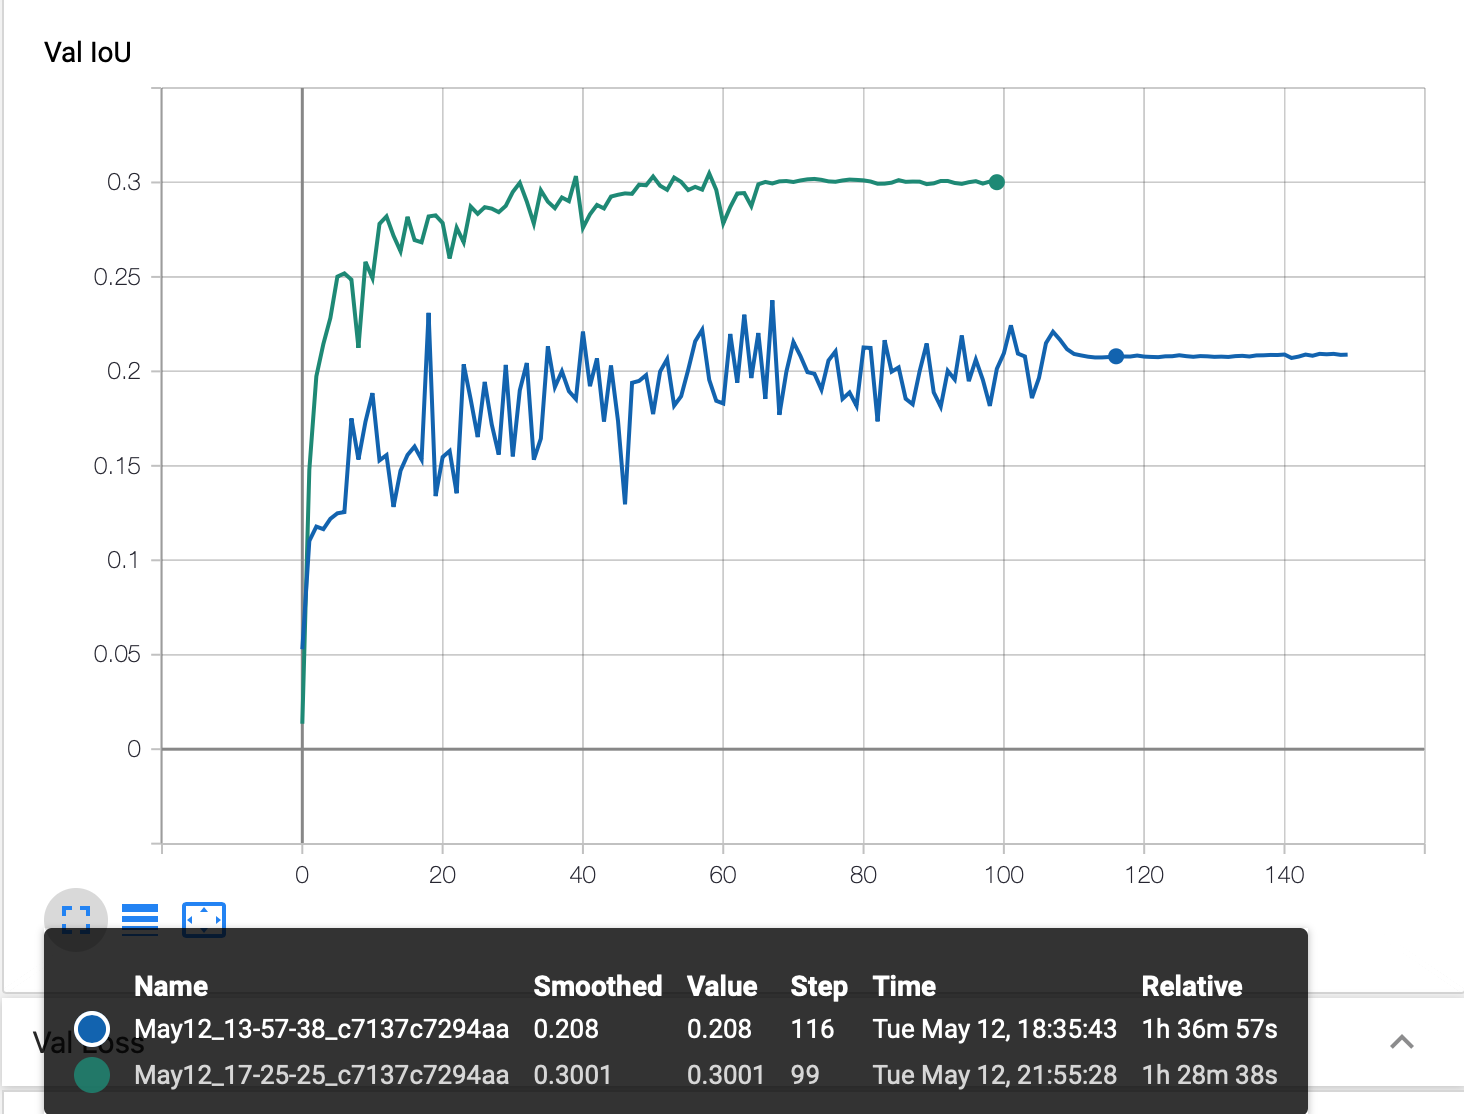

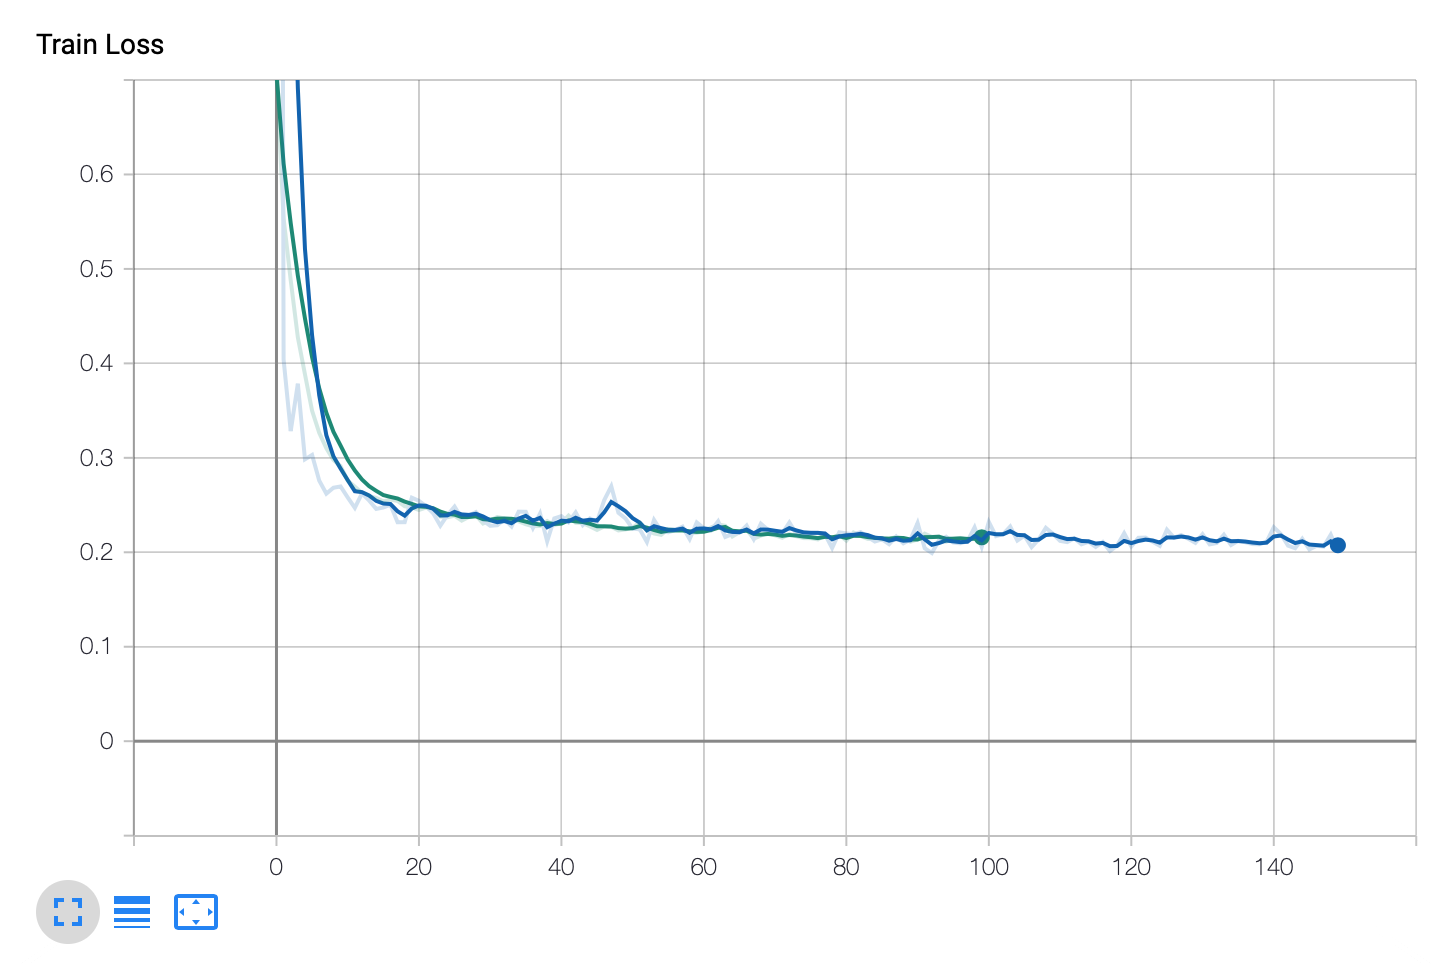

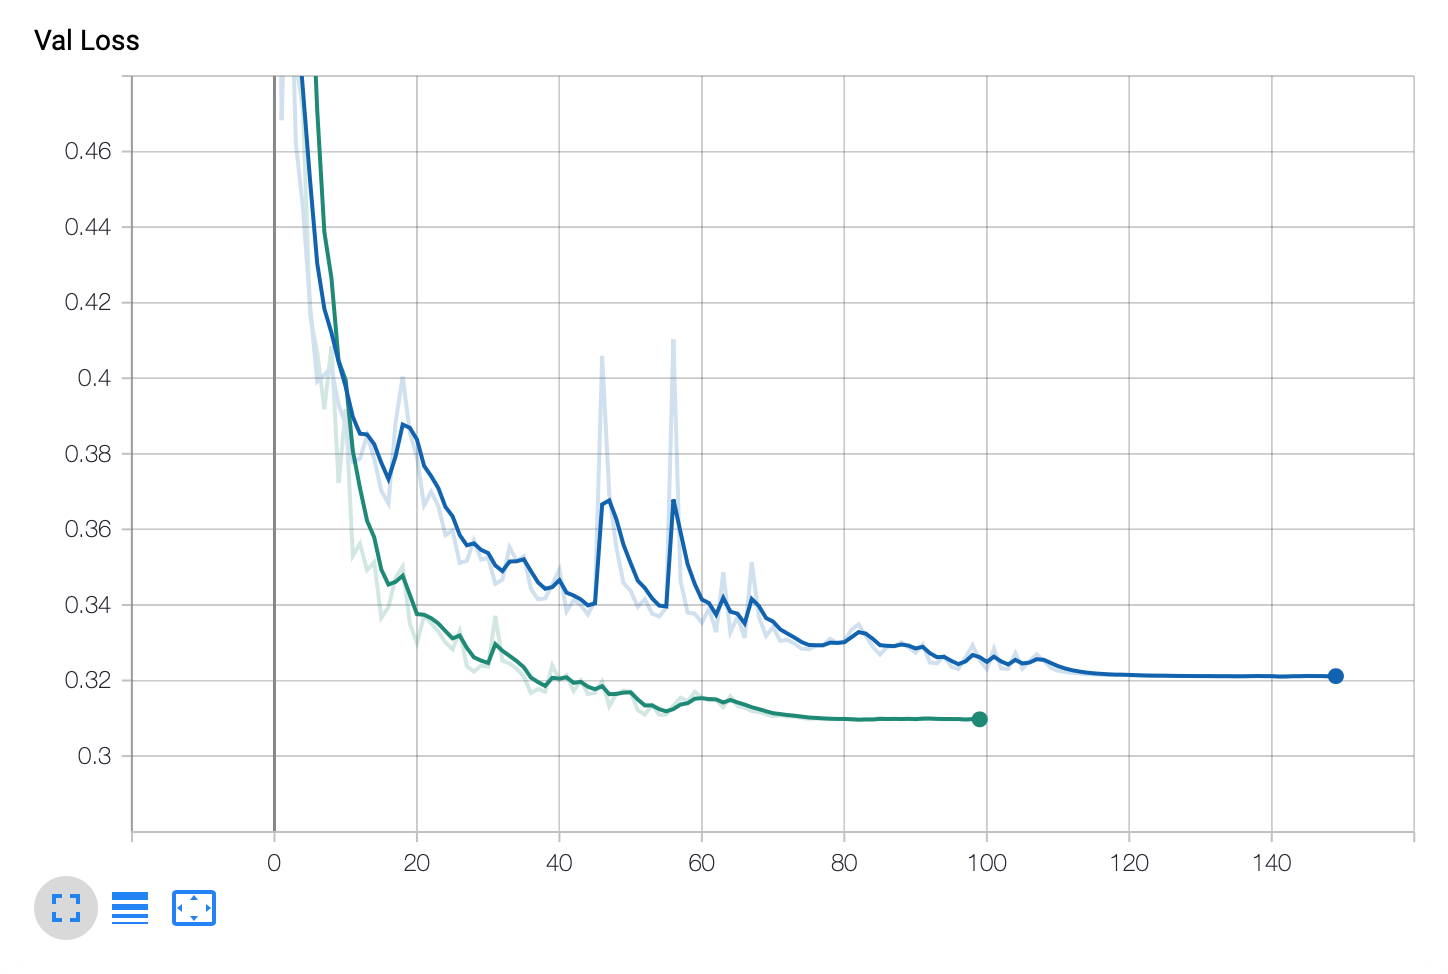

In [11]:
unet.load_state_dict(torch.load('./unet_cell_segmentation.pt', map_location='cpu'))
unet.to(device)
unet.eval()

Unet(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_size=2, st

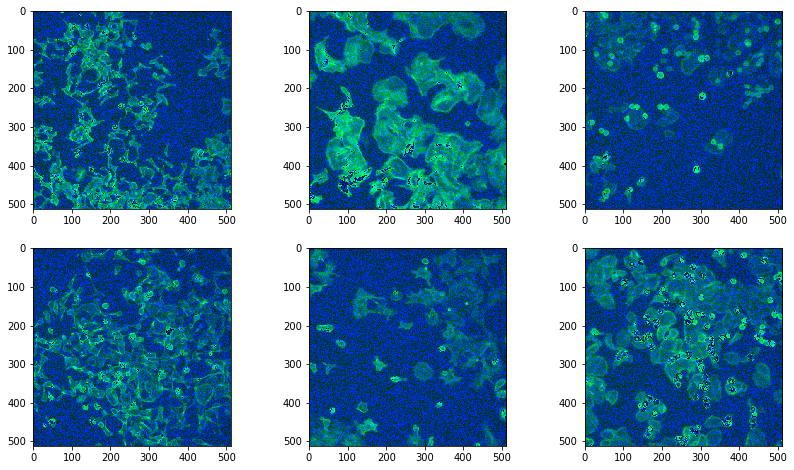

In [45]:
import glob
test_dataset = CellDataset(images_dir = './BBBC018_v1_images-fixed/test/',
                      labels_dir = './BBBC018_v1_images-fixed/test/',
                      transform = None)

test_dataloader = DataLoader(test_dataset, batch_size = 1)

sorted_paths = sorted(glob.glob(test_dataset.images_dir + '/*'))

plt.figure(figsize=(14,8))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(test_dataset[i][0])

In [44]:
test_dataset = CellDataset(images_dir = './BBBC018_v1_images-fixed/test/',
                      labels_dir = './BBBC018_v1_images-fixed/test/',
                      transform = torchvision.transforms.ToTensor())

test_dataloader = DataLoader(test_dataset, batch_size = 1)

predictions = []
for i, image in enumerate(test_dataset):
    img = image[0]
    image = img.to(device)
    output = unet(image[None])
    output = torch.sigmoid(output)
    pred = (output > 0.5)
    mask_predicted = pred.cpu().detach().numpy()[0][0]
    predictions.append(mask_predicted)

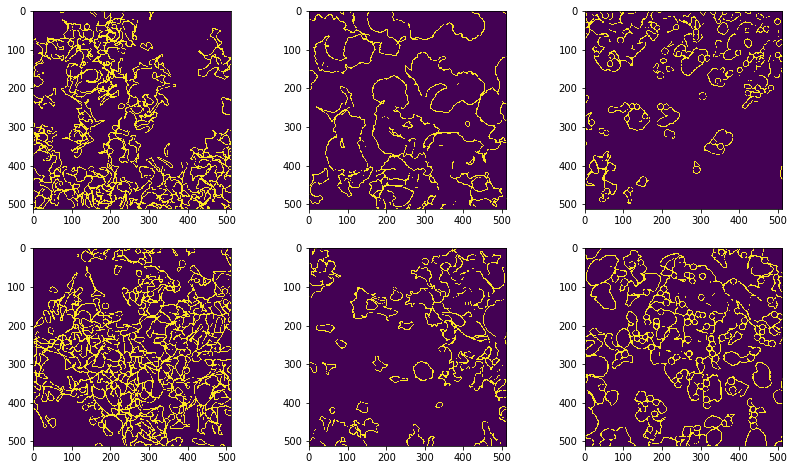

In [46]:
plt.figure(figsize=(14,8))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(predictions[i])